## Luther Kaggle Data

I am working on this data concurrently with troubleshooting my webscraping code.  I will either use this data to enrich the data I pulled or as a substitute whilst still waiting for the code to finsh running.

The first section below will be involving only the main ted data.  I will be making the assumption that the view maturity of a video will be a year after its release.  I will store all data that has not been published for more than a year in its own df, and webscrape the current views to be used as an out-of-sample test set for my model. 

In [2]:
#Importing the packages needed for this analysis
import pandas as pd
import numpy as np
import math
import re
import time
from datetime import *
from scipy import stats
import dateutil.parser
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
%matplotlib inline
%config InlineBackend.figure_format = 'png'

plt.rcParams['figure.dpi']= 400

In [2]:
#Reading in data
data = pd.read_csv('ted_main.csv')

In [3]:
#Exploring data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
comments              2550 non-null int64
description           2550 non-null object
duration              2550 non-null int64
event                 2550 non-null object
film_date             2550 non-null int64
languages             2550 non-null int64
main_speaker          2550 non-null object
name                  2550 non-null object
num_speaker           2550 non-null int64
published_date        2550 non-null int64
ratings               2550 non-null object
related_talks         2550 non-null object
speaker_occupation    2544 non-null object
tags                  2550 non-null object
title                 2550 non-null object
url                   2550 non-null object
views                 2550 non-null int64
dtypes: int64(7), object(10)
memory usage: 338.8+ KB


In [4]:
data.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [5]:
#Cleaning the DF, transforming some of the data for analysis later on
def CleanCols(df):
    df.drop('url', axis=1, inplace = True)
    df.drop('description', axis=1, inplace = True)
    df.drop('name', axis=1, inplace = True)
    df['published_date'] = data['published_date'].apply(lambda x: datetime.fromtimestamp(x).date())
    df['film_date'] = data['film_date'].apply(lambda x: datetime.fromtimestamp(x).date())
    df['days_online'] = data['published_date'].apply(lambda x: ((dateutil.parser.parse('9/22/2017').date()-x)))
    df['days_online'] = (data['days_online']/np.timedelta64(1, 'D')).astype(int)
    df['duration'] = round(data['duration']/60,2)
    #Using log views to get a better model
    df['log_views'] = data['views'].apply(lambda x: np.log(x))
    df['languages'] = df['languages'].replace(0,1)
    return df

In [6]:
#Removing unnecessary columns
CleanCols(data)

,comments,duration,event,film_date,languages,main_speaker,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,views,days_online,log_views
0,4553,19.40,TED2006,2006-02-24,60,Ken Robinson,1,2006-06-26,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,47227110,4106,17.670479
1,265,16.28,TED2006,2006-02-24,43,Al Gore,1,2006-06-26,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,3200520,4106,14.978824
2,124,21.43,TED2006,2006-02-23,26,David Pogue,1,2006-06-26,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,1636292,4106,14.307943
3,200,18.60,TED2006,2006-02-25,35,Majora Carter,1,2006-06-26,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,1697550,4106,14.344697
4,593,19.83,TED2006,2006-02-21,48,Hans Rosling,1,2006-06-27,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,12005869,4105,16.300906
5,672,21.75,TED2006,2006-02-01,36,Tony Robbins,1,2006-06-27,"[{'id': 7, 'name': 'Funny', 'count': 1102}, {'...","[{'id': 229, 'hero': 'https://pe.tedcdn.com/im...",Life coach; expert in leadership psychology,"['business', 'culture', 'entertainment', 'goal...",Why we do what we do,20685401,4105,16.844939
6,919,16.53,TED2006,2006-02-23,31,Julia Sweeney,1,2006-07-09,"[{'id': 3, 'name': 'Courageous', 'count': 477}...","[{'id': 22, 'hero': 'https://pe.tedcdn.com/ima...","Actor, comedian, playwright","['Christianity', 'God', 'atheism', 'comedy', '...",Letting go of God,3769987,4093,15.142582
7,46,19.97,TED2006,2006-02-22,19,Joshua Prince-Ramus,1,2006-07-09,"[{'id': 9, 'name': 'Ingenious', 'count': 195},...","[{'id': 750, 'hero': 'https://pe.tedcdn.com/im...",Architect,"['architecture', 'collaboration', 'culture', '...",Behind the design of Seattle's library,967741,4093,13.782720
8,852,24.75,TED2006,2006-02-01,32,Dan Dennett,1,2006-07-17,"[{'id': 3, 'name': 'Courageous', 'count': 562}...","[{'id': 71, 'hero': 'https://pe.tedcdn.com/ima...","Philosopher, cognitive scientist","['God', 'TED Brain Trust', 'atheism', 'brain',...",Let's teach religion -- all religion -- in sch...,2567958,4085,14.758622
9,900,21.03,TED2006,2006-02-24,31,Rick Warren,1,2006-07-17,"[{'id': 21, 'name': 'Unconvincing', 'count': 8...","[{'id': 94, 'hero': 'https://pe.tedcdn.com/ima...","Pastor, author","['Christianity', 'God', 'culture', 'happiness'...",A life of purpose,3095993,4085,14.945619


In [7]:
#Setting aside videos that had been online for less than a year to use as an out of sample test set for the model
test_df = data[data.days_online < 364]


In [8]:
# Filtering out the test set
data = data[data['days_online'] >= 365]

## Preliminary Plots 

Making some preliminary plots to get a better idea of what the data shows and to help decide what factors will be incorporated in the linear regression.  I will need to find a way to normalize the time component so we are comparing apples to apples. 

As seen below, log_views has the greatest correlation with the number of languages the transcript is available in and the amount of comments.  The former makes sense because the broader the audience, the more views it will get.  The latter (comments) is most likely true for 2 reasons. First, if someone leaves a comment, they will return to the page later to see other comments or respond to comments on their comment.  Either case counts as another 'view'.  Secondly, the comments can be an indicator about how people enjoyed the video and if a video is enjoyable.

In [9]:
#Beginning preliminary graphing
import matplotlib.pyplot as plt
import seaborn as sns


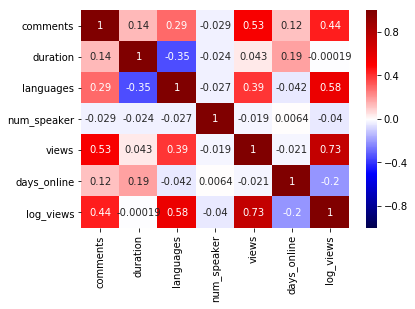

In [10]:
# Checking the data for correlations between variables
plt.savefig("test.png", format="png")
sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap=('seismic'), annot = True)

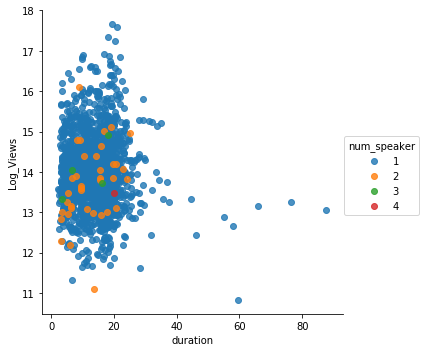

In [11]:
#There really is no correlation between duration and number of speakers, or view count
fig = sns.lmplot(y="log_views", x="duration", data=data, hue = 'num_speaker', fit_reg = False)
fig = fig.set_axis_labels('duration', 'Log_Views')

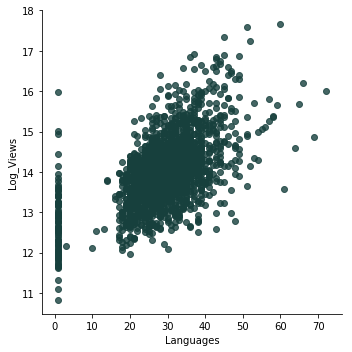

In [12]:
#Changing color palette, plotting logviews against languages that the video is available in
sns.set_palette(sns.cubehelix_palette(8, start=1.5, rot=1.5, dark=.6, light=.2))
fig = sns.lmplot(y="log_views", x='languages', data=data, fit_reg = False)
fig = fig.set_axis_labels('Languages', 'Log_Views')

In [13]:
#Extracting the indeces for the highest view count for reference
four_highest = data[data.views>21000000].ratings.index
four_highest

Int64Index([0, 201, 452, 677, 837, 1346, 1776], dtype='int64')

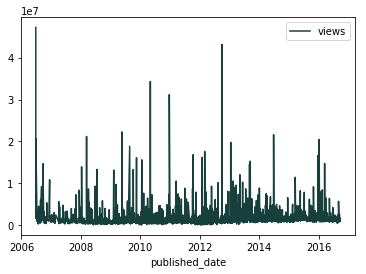

In [14]:
#Checking how the views changed based on when the video was put online
data[['published_date','views']].set_index('published_date').plot()

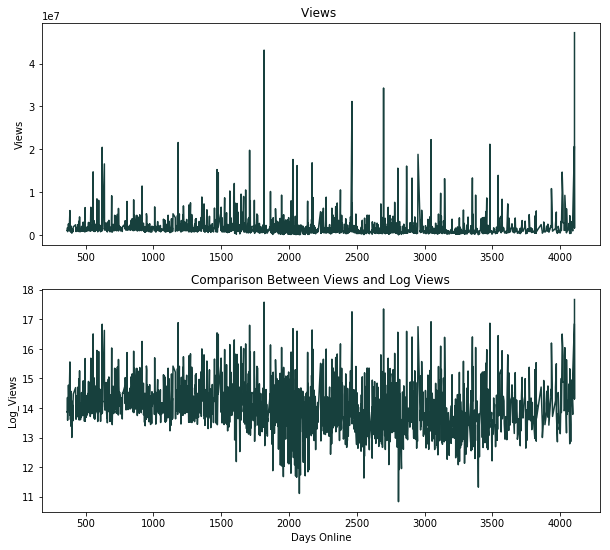

In [15]:
#Ploting the log_views versus views against days available online
fig, ax = plt.subplots(2, 1, figsize=(10, 9))  # 2 Rows, 1 Col

ax[0].plot(data['days_online'],data['views'])
ax[0].set_title('Views ')
ax[0].set_ylabel('Views')

ax[1].plot(data['days_online'], data['log_views'])
ax[1].set_xlabel('Days Online')
ax[1].set_ylabel('Log_Views')
ax[1].set_title('Comparison Between Views and Log Views');


## Pulling out reactions

Each video has its own ratings, or reactions the watchers have during or after the video.  The number of reactions were changed to proportions to normalize for each video, so we can compare the distribution of reactions based on number of views and other factors. 

In [16]:
data.reset_index(drop=True, inplace=True)

In [17]:
#Pulls the number of tags for a certain tag
def FindTag(tag, sl):
    hand = False
    count = 0
    for i in sl:
        if tag in i:
            hand = True
        elif hand == True:
            count = int(i.split('}')[0].strip())
            hand= False
    return count

In [18]:
# calling in each tag individually to run through the broken comment.  I am doing this so its easier to 
# join the dataframes later (and match the number to the correct column)
def CrackShell(string):
    tag_list=['Courageous', 'Beautiful', 'Confusing', 'Funny', 'Ingenious', 'Unconvincing', \
          'Longwinded', 'Informative', 'Inspiring', 'Fascinating', 'Persuasive', 'Jaw-dropping','Obnoxious']
    comment = string.split(':')
    emotes = []
    for i in tag_list:
        emotes.append(FindTag(i, comment))
    return emotes

In [19]:
#creates the reaction dictionary (emote_dict), and passes all possible reactions to the functions defined above
emote_dict = {}
tag_list=['Courageous', 'Beautiful', 'Confusing', 'Funny', 'Ingenious', 'Unconvincing', \
          'Longwinded', 'Informative', 'Inspiring', 'Fascinating', 'Persuasive', 'Jaw-dropping','Obnoxious']
for i in range(len(data.ratings)):
        emote_dict[i] = CrackShell(data.ratings[i])

In [20]:
#Turning dictionary into Dataframe
from pandas import DataFrame
emote_df = pd.DataFrame.from_dict(emote_dict, orient = 'index')

In [21]:
#adding column names to DF, then changing reaction count to reaction proportion, the last line is checking
# that the proportions do not exceed 1
emote_df.columns = tag_list
for i in range(0,len(emote_df.index)):
    emote_df.loc[i,:] = emote_df.loc[i,:] / emote_df.loc[i,:].sum()

In [22]:
#combining reaction DF with the original DF (data), then dropping the ratings column as it is no longer needed.
df= data.join(emote_df)
df= df.drop('ratings', axis=1)

In [23]:
#Tags suspected of multicollinearity
drop_tag_list=['Courageous', 'Beautiful','Ingenious','Informative','Persuasive']

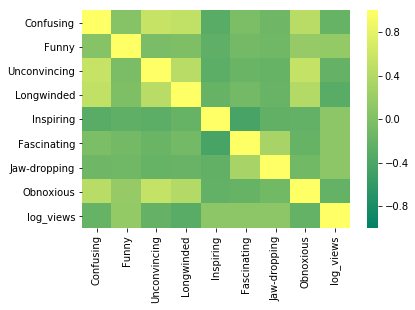

In [24]:
#What correlations can i see from the ratings
emote_heat = emote_df.copy()
emote_heat['log_views'] = data['log_views']
sns.heatmap(emote_heat.drop(drop_tag_list,1).corr(), cmap='summer', vmin = -1, vmax=1)

## Pulling out tags for dummy variables

The ratings seen above some some interesting correlations, with correlations approximately between 0.2 and -0.4.  Are these correlations significant? Most of them are not.  Pushing further, we can get the tags associated with each video and use them to distinguish if the tags of a video affect the number of views.

The goal is to pull out the tags associated with each video, then apply them as dummy variables in order to decide if they have a big affect on total views.  Dropping all tags with less than 20 tags associated with it.

In [25]:
#Creating a list of unique tags
def uniqueitems(unfiltered):
    unique_list = []
    for x in unfiltered:
        if x not in unique_list and len(x)>4:
            unique_list.append(x)
    return unique_list 

In [26]:
# Creating a dictionary similar to a default dictionary where the first row will be all 1s
def allthetags(extagaganza):
    tags = []
    dummy_dict = {}
    for i in range(len(extagaganza)):
        check = extagaganza[i]
        if type(check) == str:
            tagg = check.split('\'')
            taglen = len(tagg)
            for k in range(1,taglen,2):
                tags.append(tagg[k])
        elif type(check) ==list:
            taglen = len(check)
            for k in range(1,taglen):
                tags.append(check[k])
    uni_tag = uniqueitems(tags)
    for i in uni_tag:
        dummy_dict[i] = [1]
    return dummy_dict, uni_tag


In [27]:
#Taking the dictionary created in allthetags and assigning 0s or 1s in the appropriate lists to create categorical 
#column values
tag_dict={}
tag_dict, unitags = allthetags(data.tags)
for i in range(len(data.tags)):
    tagg = data.tags[i].split('\'')
    taglen = len(tagg)
    tags = [tagg[k] for k in range(1,taglen,2)]
    # for loop  to fill in 1s and 0s for the dummy variables
    for d in tag_dict:
        if d in tags:
            tag_dict[d].append(1)
        else:
            tag_dict[d].append(0) 


In [28]:
#Turns the dictionary into a DF, and drops first row because it was the initialization row
tag_df = pd.DataFrame(tag_dict) 
tag_df.drop(0, inplace=True)
tag_df.reset_index(drop=True, inplace = True)

In [29]:
#Filtering out the tags lower in number to get a sense of which tags are most prominent
top_tags= []
for i in unitags:
    tots_tags = tag_df.loc[:,i].sum()
    if tots_tags <130:
        tag_df.drop(i, 1,inplace=True)
    else:
        top_tags.append(i)
        


In [30]:
#Dummy variable dataframe
inter_df = df.copy()
inter_df.drop('num_speaker',axis=1, inplace =True)
inter_df.drop('related_talks',axis=1, inplace =True)
inter_df.drop('speaker_occupation',axis=1, inplace =True)

In [31]:
#Getting everything together in one place
tag_df = inter_df.join(tag_df)


In [32]:
#Just curious, four_highest was originally 4, but I wanted to see the gap as well.
tag_df.loc[four_highest,['main_speaker','views',  'log_views', 'duration']].sort_values('views', ascending=False)

,main_speaker,views,log_views,duration
0,Ken Robinson,47227110,17.670479,19.40
1346,Amy Cuddy,43155405,17.580318,21.03
677,Simon Sinek,34309432,17.350931,18.07
837,Brené Brown,31168150,17.254907,20.32
452,Mary Roach,22270883,16.918791,16.72
1776,Julian Treasure,21594632,16.887955,9.97
201,Jill Bolte Taylor,21190883,16.869082,18.32


## Regression Analysis

Below starts the linear regression and feature engineering section of the code.  All the code up to this point has been prepping exploring the data for this phase.  Exploring the data will help us validate and troubleshoot the model depending on the outcome. I will use StatsModels, and Sklearn ElasticNetCV.  The models require a little more data processing, which is down in the beginning of the section.

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.cross_validation import cross_val_score


/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [34]:
#Scaling data for a better model
def Polish(df):
    df['comments'] = preprocessing.scale(df['comments'])
    df['languages'] = (df['languages'].apply(lambda x: (x-df['languages'].min())/(df['languages'].max()-df['languages'].min())))
    df['days_online'] = df['days_online'].apply(lambda x: math.log(x))
    df['duration'] = preprocessing.scale(df['duration'])
    df.drop(['event', 'film_date', 'main_speaker', 'published_date', 'tags', 'title', 'views'],1, inplace = True)
    df.drop(drop_tag_list,1, inplace = True)
    return df   

In [35]:
tag_df = Polish(tag_df)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [36]:
tag_df.to_csv('tedtalk.csv', encoding='utf-8', index = False)

In [37]:
#Creating a set to train on and a set to test on
y = tag_df.log_views
X = tag_df.drop('log_views',1)
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 5)

In [38]:
#Checking StatsModels analysis for more interpretability
model1 = sm.OLS(y_train,X_train)
fit1 = model1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_views   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     80.63
Date:                Mon, 30 Apr 2018   Prob (F-statistic):          6.13e-292
Time:                        08:18:21   Log-Likelihood:                -1151.3
No. Observations:                1600   AIC:                             2365.
Df Residuals:                    1569   BIC:                             2531.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            15.4991      0.206     75.419      0.000      15.096      15.902
comments          0.2257      0.014     16.071      0.000       0.198       0.253
duration          0.1473      0.016      9.504      0.000       0.117       0.178
languages         3.1934      0.125     25.464      0.000       2.947       3.439
days_online      -0.4451      0.027    -16.455      0.000      -0.498      -0.392
Confusing         2.4053      0.913      2.633      0.009       0.613       4.197
Funny             1.6903      0.168     10.067      0.000       1.361       2.020
Unconvincing     -0.3021      0.421     -0.718      0.473      -1.127       0.523
Longwinded       -1.6693      0.633     -2.638      0.008      -2.910      -0.428
Inspiring         0.9298      0.171      5.446      0.000       0.595       1.265
Fascinating       1.5644      0.239      6.542      0.000       1.095       2.033
Jaw-dropping      2.4901      0.261      9.554      0.000       1.979       3.001
Obnoxious        -0.8933      0.635     -1.406      0.160      -2.139       0.353
biology          -0.0816      0.054     -1.518      0.129      -0.187       0.024
brain             0.2330      0.056      4.166      0.000       0.123       0.343
business          0.2564      0.039      6.578      0.000       0.180       0.333
creativity        0.0101      0.048      0.210      0.834      -0.085       0.105
culture           0.1123      0.034      3.344      0.001       0.046       0.178
design           -0.0347      0.035     -0.982      0.326      -0.104       0.035
economics         0.0565      0.058      0.973      0.330      -0.057       0.170
education         0.0642      0.055      1.171      0.242      -0.043       0.172
entertainment    -0.0205      0.042     -0.488      0.626      -0.103       0.062
environment      -0.0025      0.055     -0.046      0.963      -0.111       0.106
future           -0.0514      0.057     -0.894      0.372      -0.164       0.061
global issues    -0.1680      0.034     -4.877      0.000      -0.236      -0.100
health            0.1093      0.051      2.142      0.032       0.009       0.209
innovation       -0.0334      0.053     -0.628      0.530      -0.138       0.071
medicine         -0.1089      0.061     -1.784      0.075      -0.229       0.011
science          -0.1111      0.038     -2.944      0.003      -0.185      -0.037
social change    -0.0240      0.053     -0.451      0.652      -0.128       0.080
technology       -0.0133      0.031     -0.426      0.670      -0.074       0.048
==============================================================================
Omnibus:                      139.980   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              866.450
Skew:                           0.039   Prob(JB):         

In [39]:
#Creating a set to train on and a set to test on
y = tag_df.log_views
X = tag_df.drop('log_views',1)
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 5)

#Checking Sklearns ElasticNetCV, a higher l1_ratio means I am safe of multicollinearity
est =  ElasticNetCV(l1_ratio = .95, cv=20, n_alphas= 200)
est.fit(X_train,y_train)
est.score(X_train,y_train)


0.6041294313990735

In [40]:
#Test scores are a little bit lower, to be expected
est.score(X_test, y_test)

0.6383290807134753

In [41]:
#Getting multiplicative error to see my models absolute fit
rms = math.sqrt(mean_squared_error(y_test, est.predict(X_test)))
math.exp(rms)

1.6289914925553264

In [42]:
adj = 1 - ((sum((y_test-est.predict(X_test))**2.0)/(len(X_test) - len(est.get_params()) - 1))
                /(sum((y_test - np.mean(y_test))**2.0)/(len(X_test) - 1)))    #compute the adjusted r2 in the test set
adj

0.6296921632379757

In [714]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
        
    pred = est.predict(x)
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

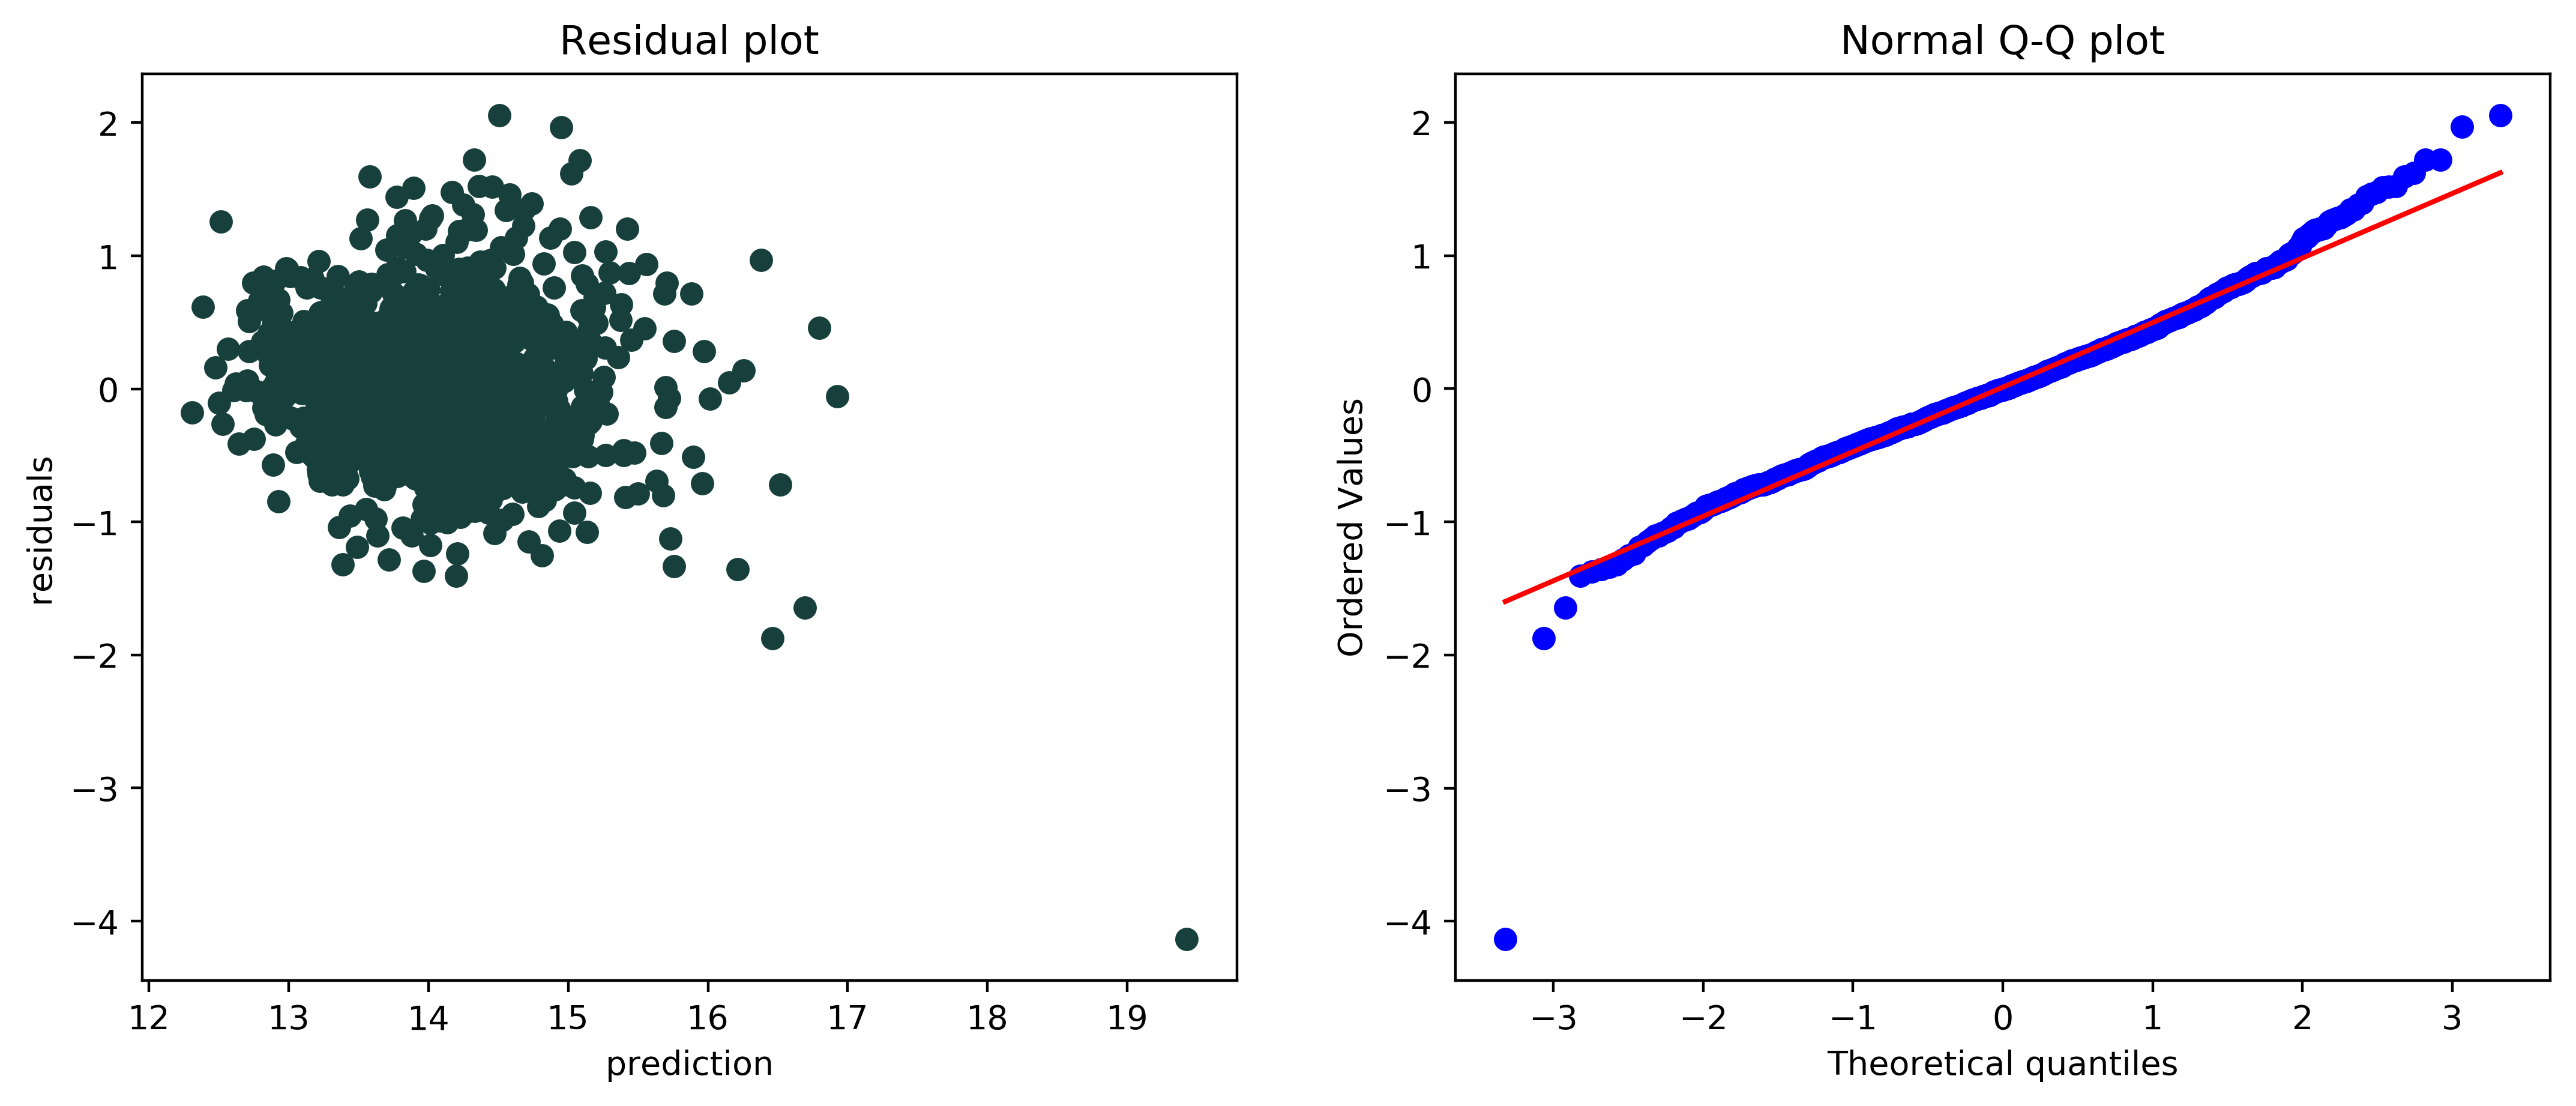

In [610]:
#Checking residuals and quantile plots
diagnostic_plot(X_test, y_test)

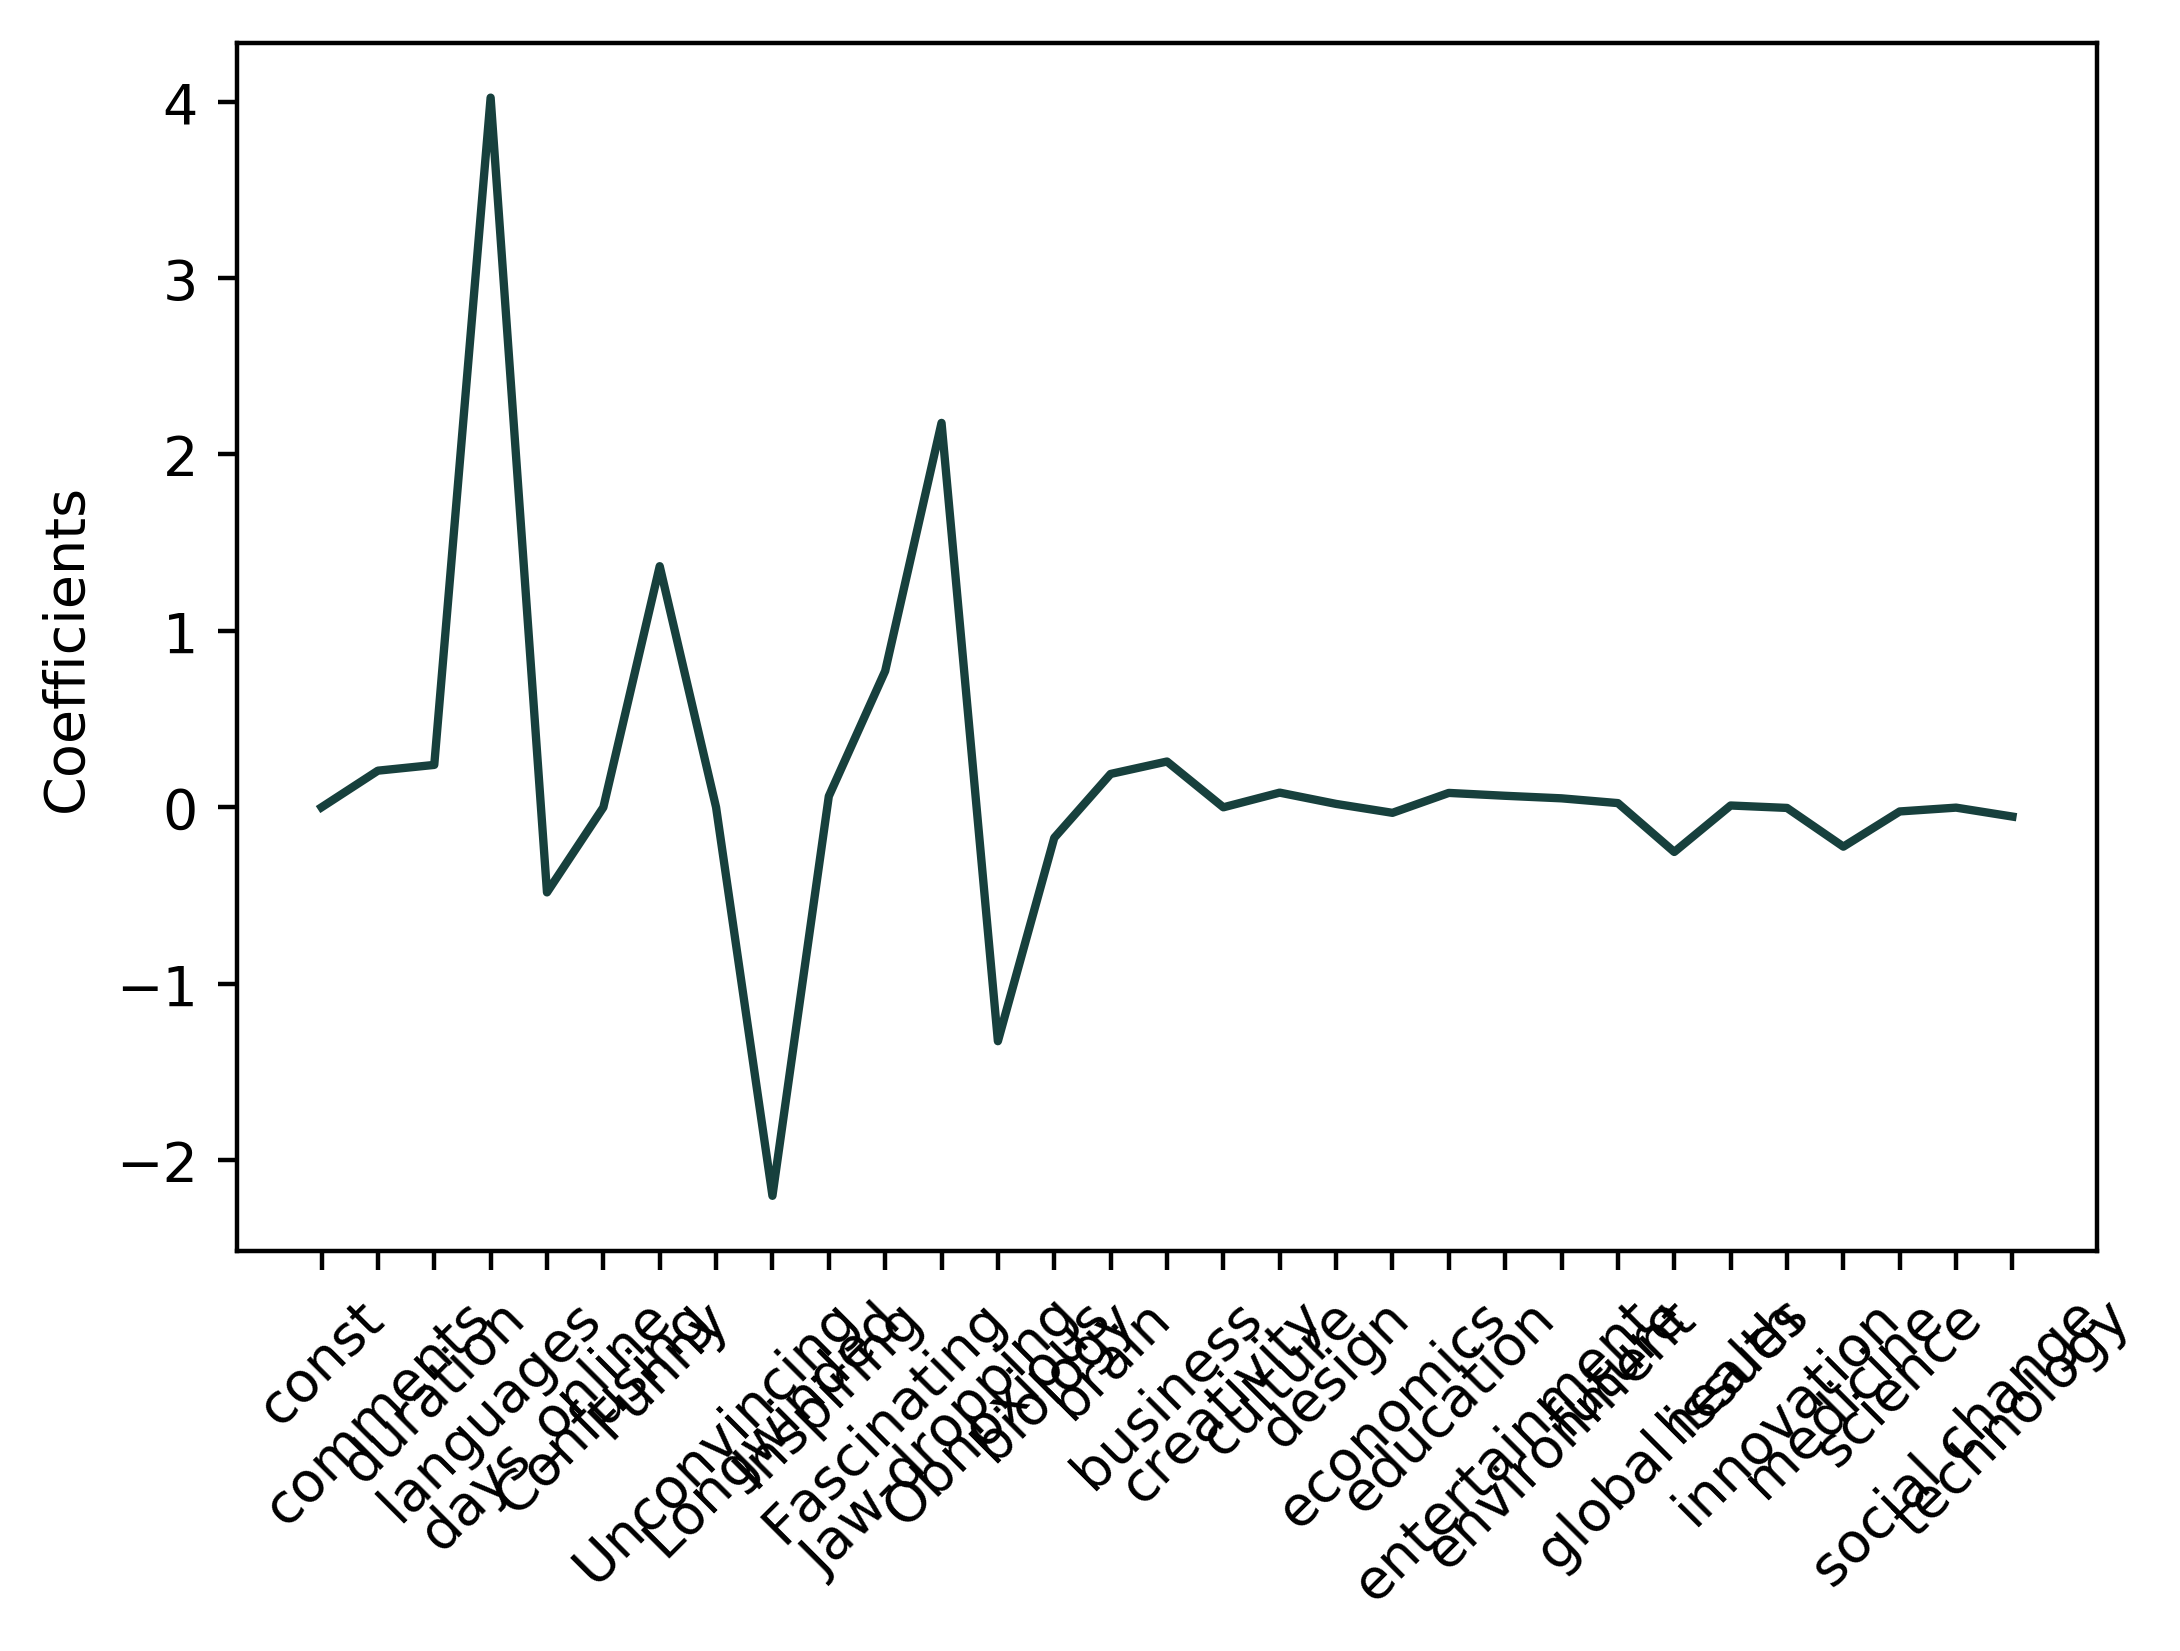

In [611]:
#Looking at the most influencial variable in my models
encv_coef = est.coef_
_ = plt.plot(range(len(X_train.columns)), encv_coef)
_ = plt.xticks(range(len(X.columns)), X.columns, rotation=45)
_ = plt.ylabel('Coefficients')
plt.show()


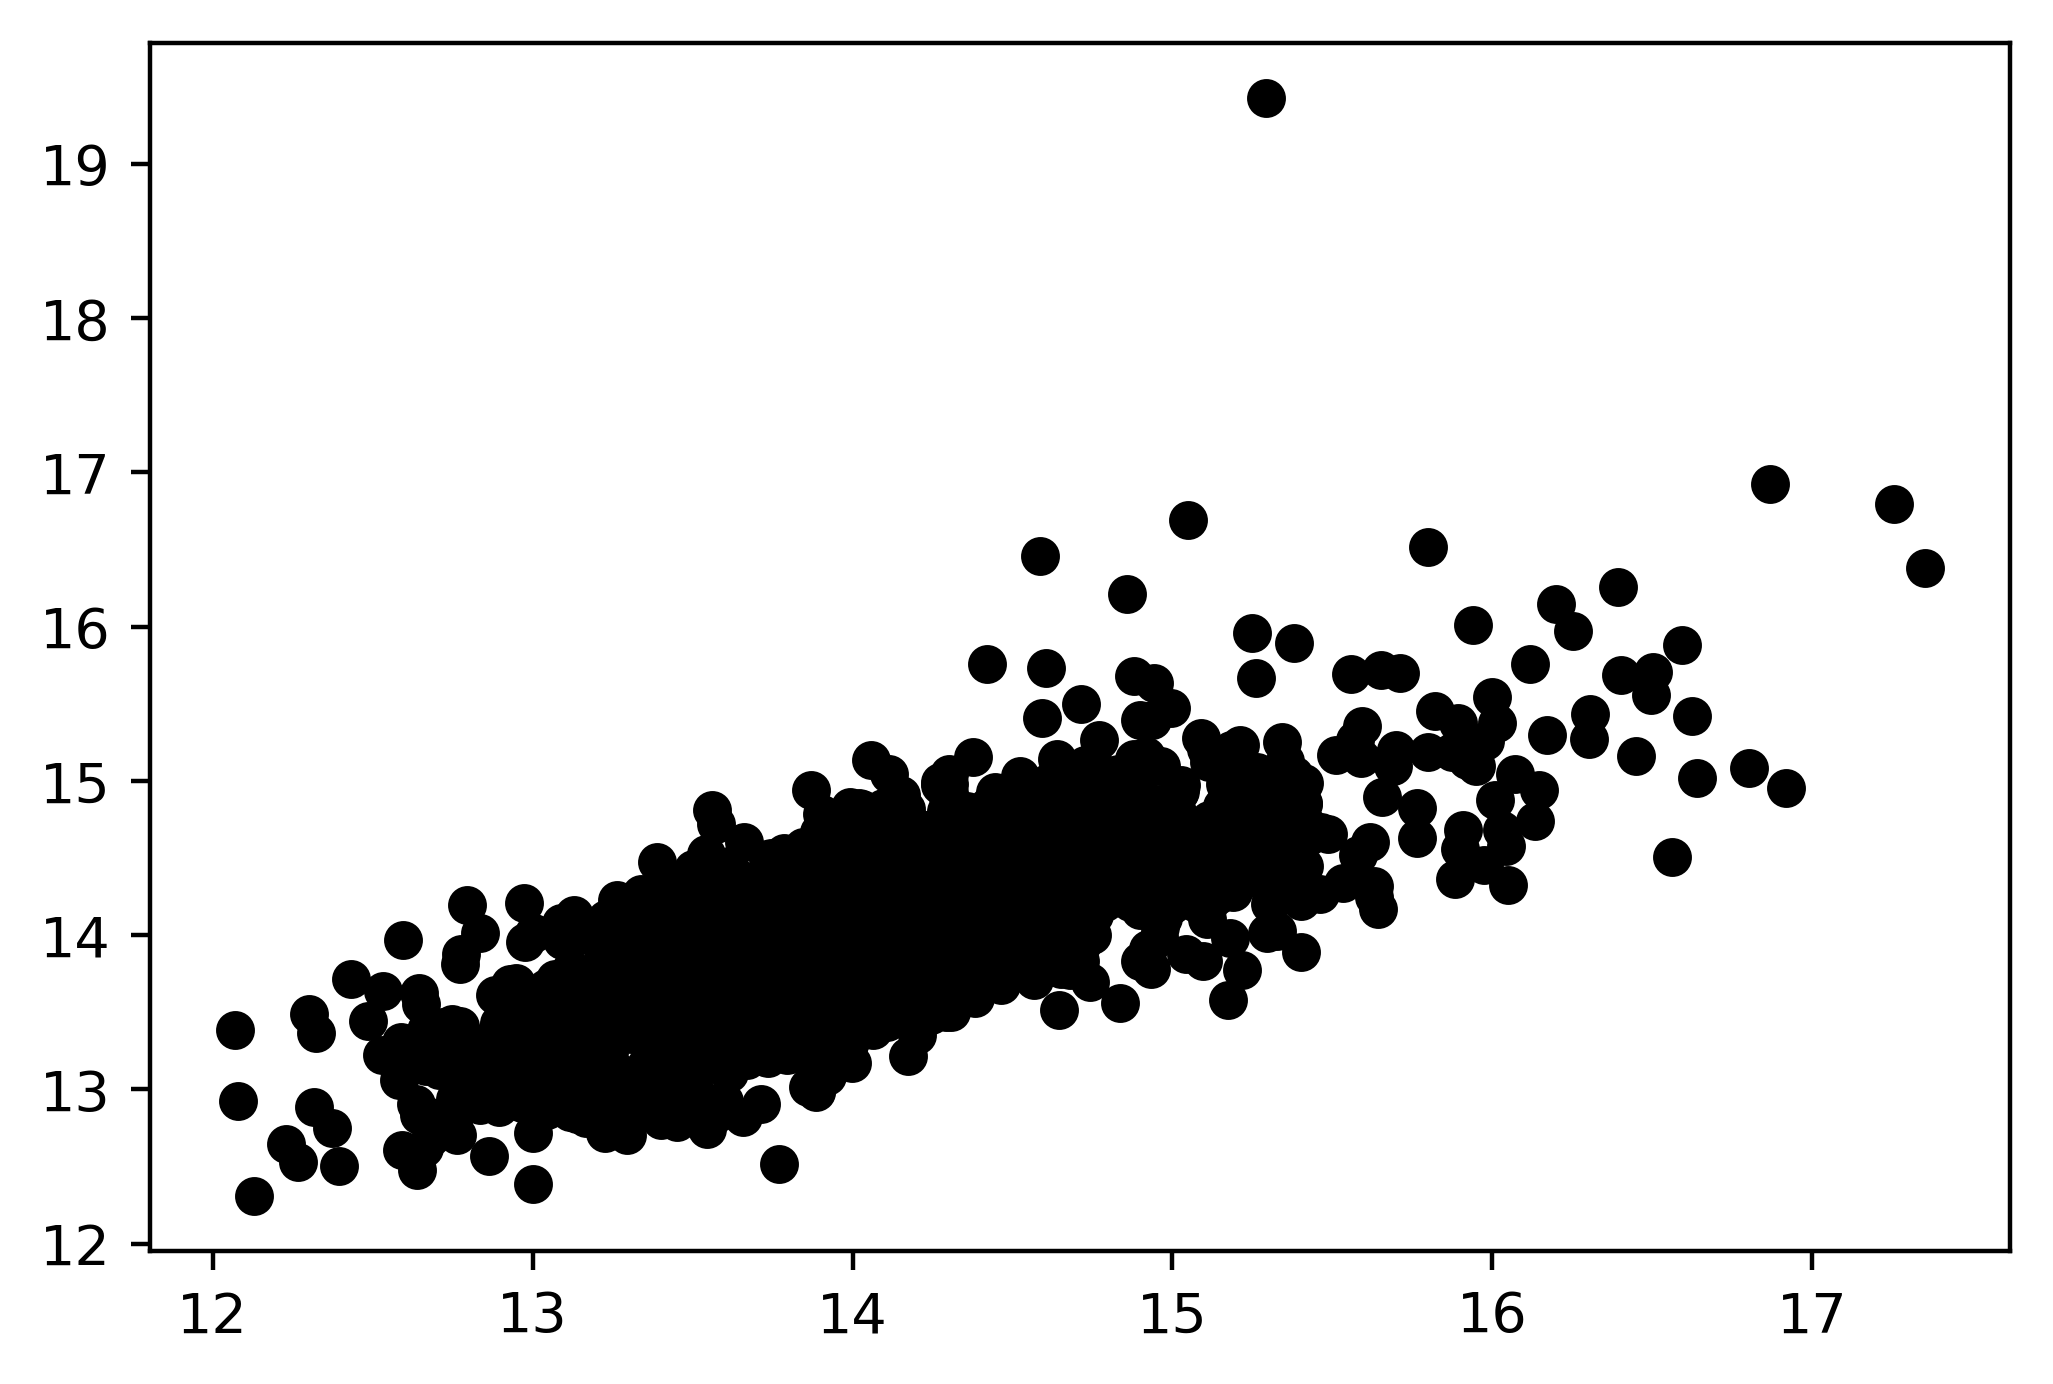

In [612]:
#Plotting predicted vs actual y for my test set
y_pred = est.predict(X_test)

# Plot outputs
plt.scatter(y_test, y_pred, color= 'black')

plt.show()

In [680]:
#Getting top mean fascinating scores of each category
cat = []
rate_mean = []
view_mean = []
for i in top_tags:
    mean = tag_df[tag_df[i]==1]['Fascinating'].mean()
    cat.append(i)
    rate_mean.append(mean)
#Deleting some categories with low Fascinating ratings to make the graph easier to read
indices = 0,1,4,7,8,9,11,13,14,17,19,20,22,23,25,26,27,28,29
cat = [i for j, i in enumerate(cat) if j not in indices]
rate_mean = [i for j, i in enumerate(rate_mean) if j not in indices]

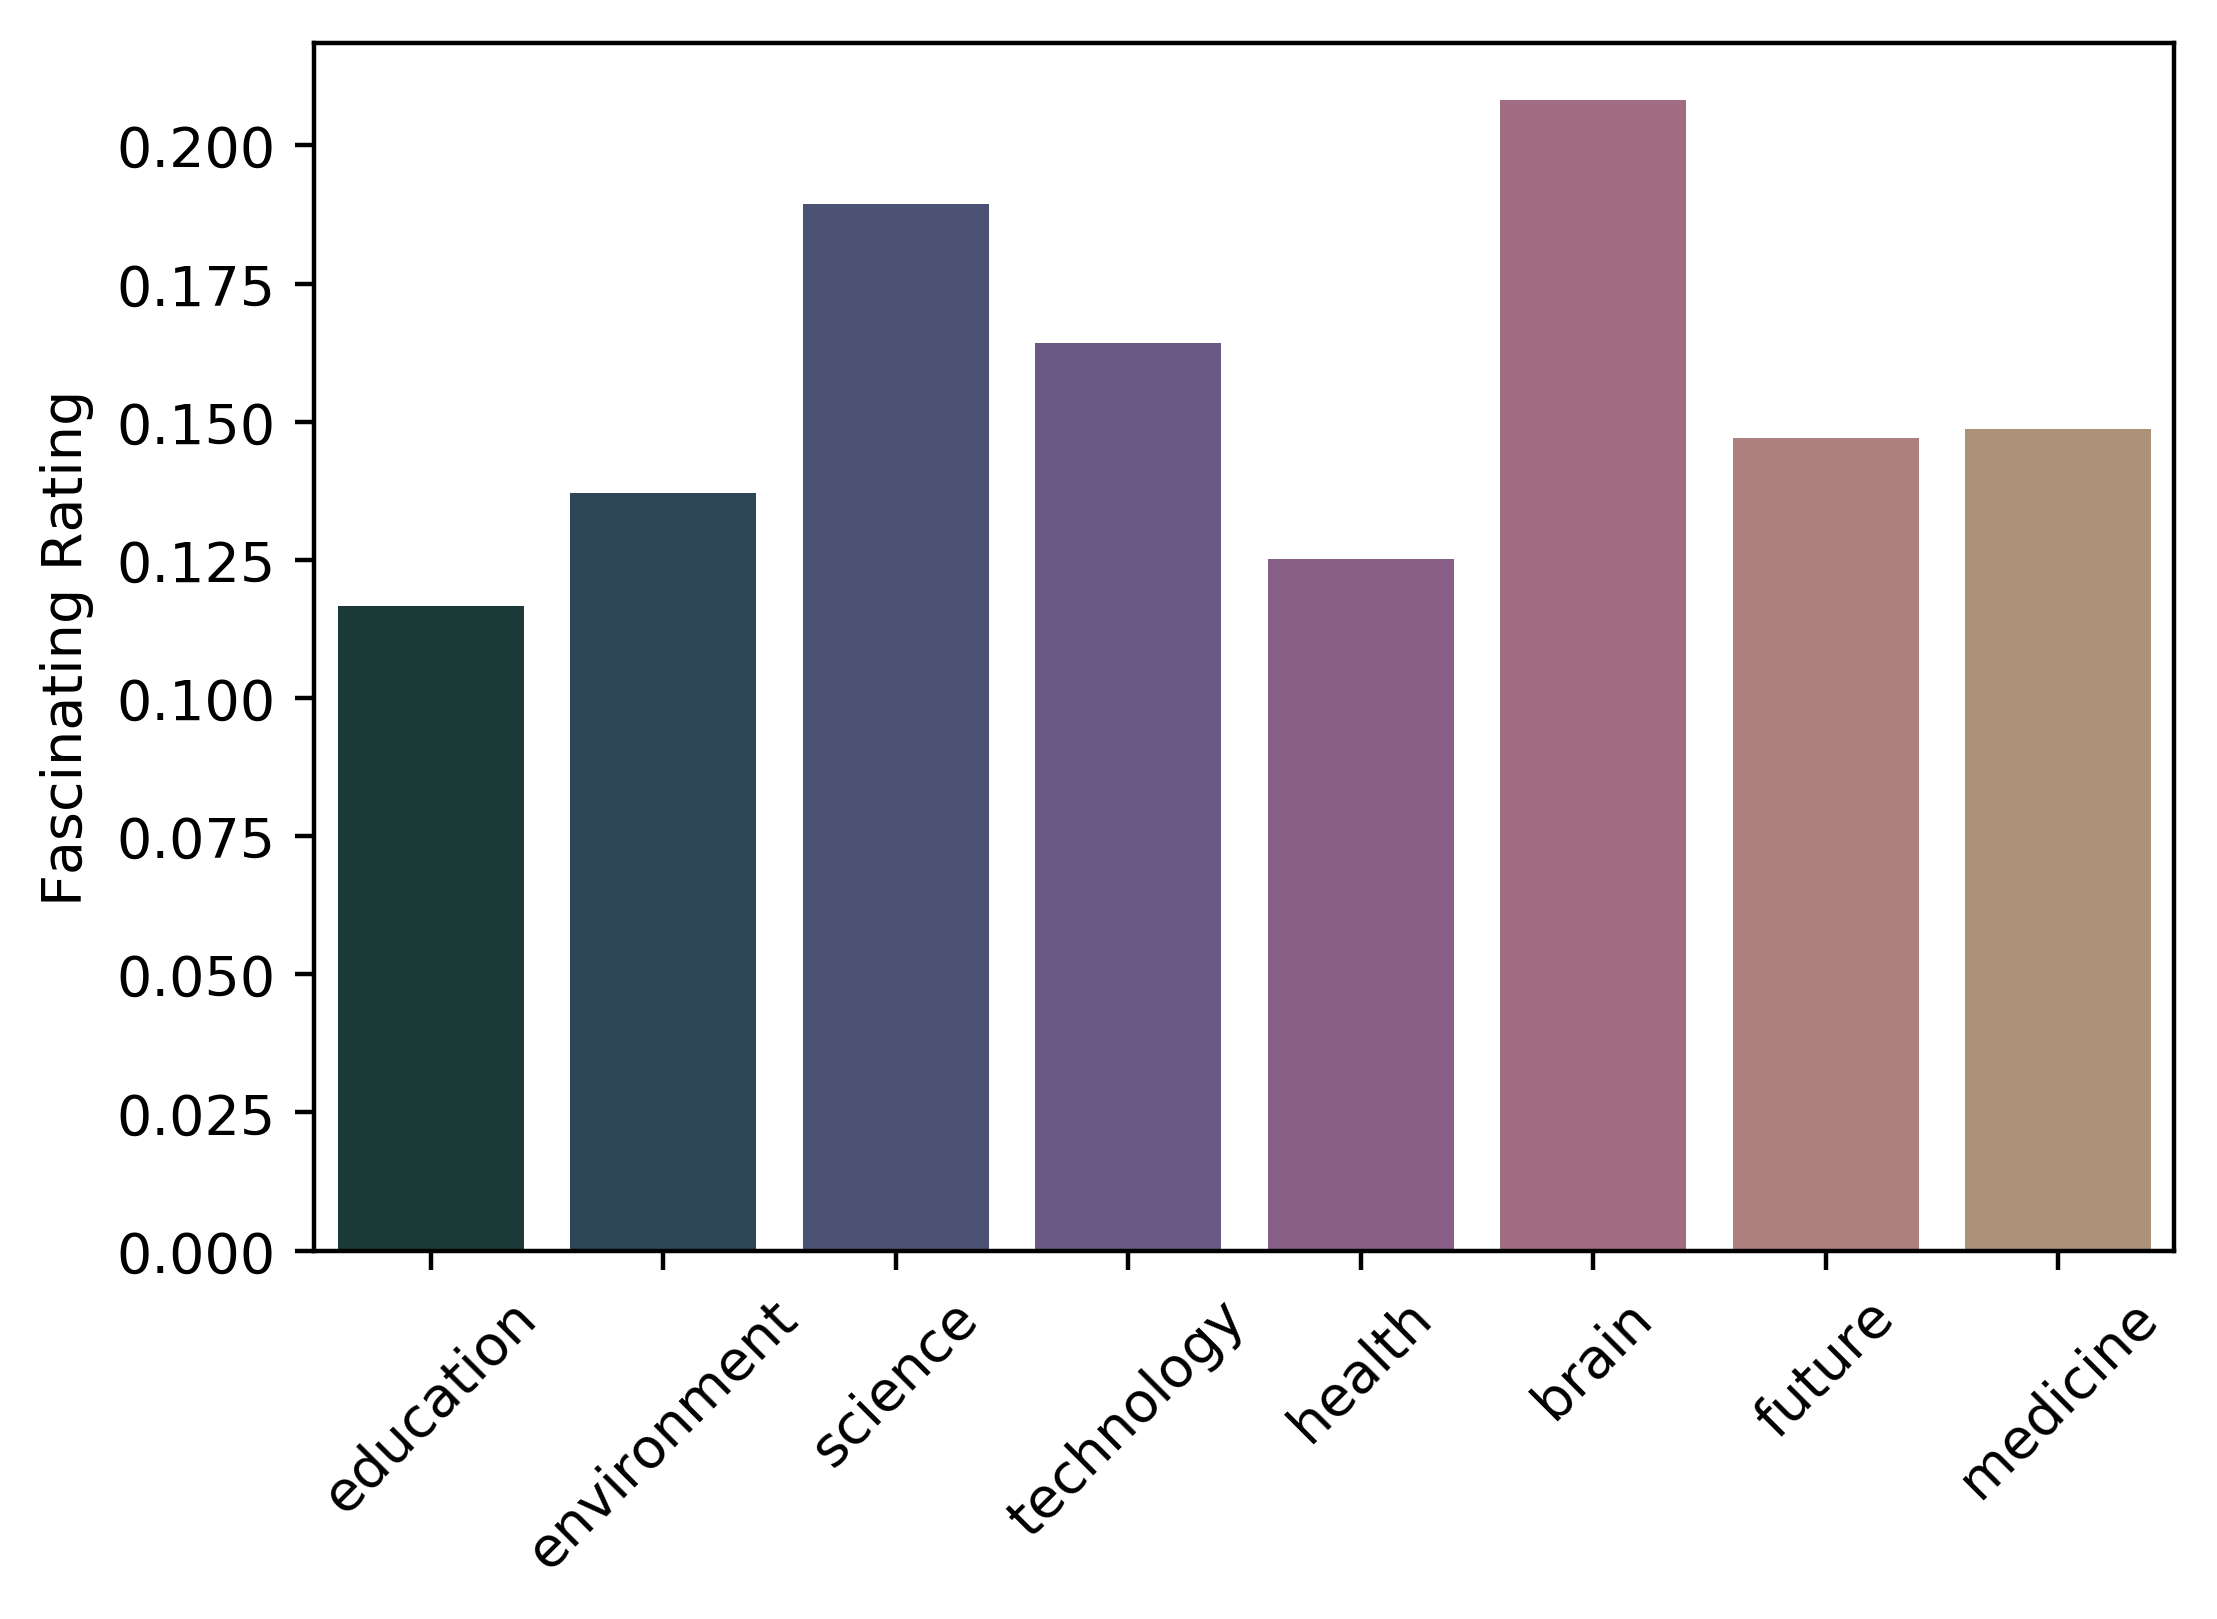

In [692]:
#Creating graph to show off the differencese
sns.barplot(cat, rate_mean)
_ = plt.xticks(rotation=45)
_ = plt.ylabel('Fascinating Rating')

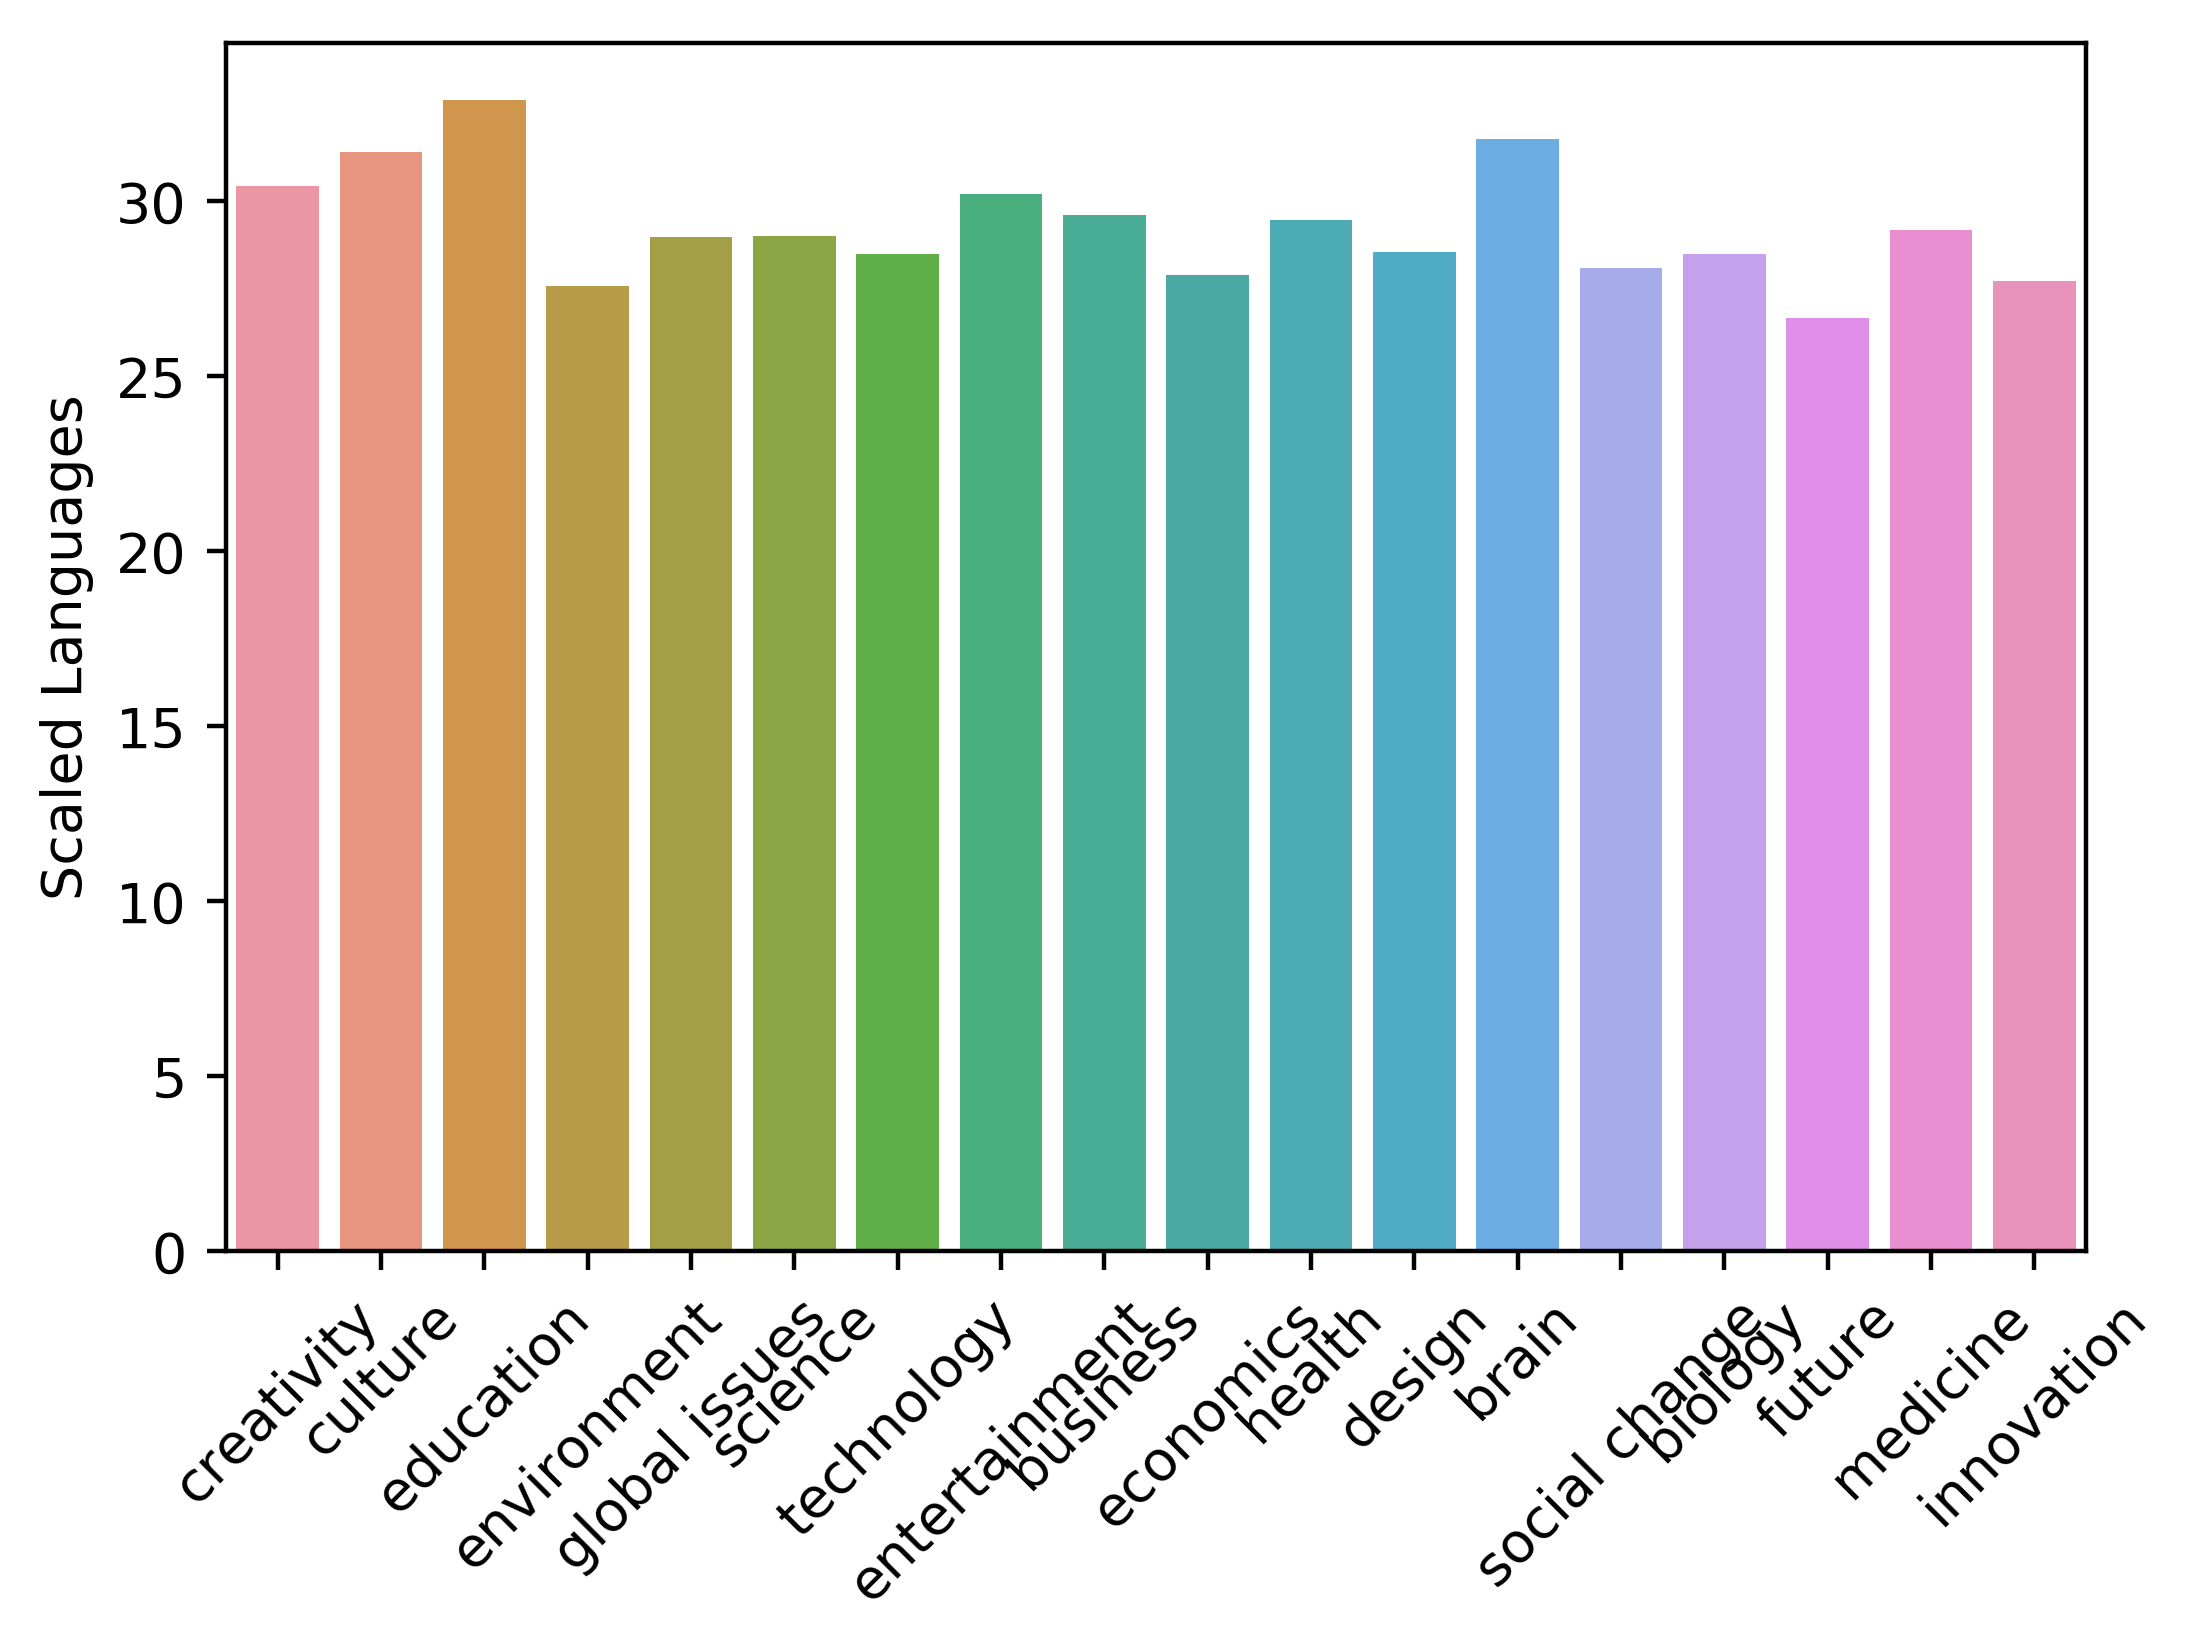

In [693]:
#Getting top mean language scores of each category
cat = []
rate_mean = []
mean_coms = []
for i in top_tags:
    mean = tag_df[tag_df[i]==1]['Fascinating'].mean()
    mean2 = tag_df[tag_df[i]==1]['languages'].mean()
    cat.append(i)
    rate_mean.append(mean)
    mean_coms.append(mean2)
#Creating graph to show off the differencese
sns.barplot(cat, mean_coms)
_ = plt.xticks(rotation=45)
_ = plt.ylabel('Scaled Languages')

## Transcripts of Presentations

Below is an analysis over the transcripts to see if any insight can be found.  We saw above that videos people thought were fascinating had a postive relationship with view count. We can explore that and other correlations such as sentiment scores to see if they have an affect on views.

In [4]:
#Importing textblob, and reading in the transcripts as a dataframe
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
transcripts = pd.read_csv('transcripts.csv')
#colors = sns.diverging_palette(10, 220, sep=80, n=7)


In [5]:
transcripts.head()

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


In [7]:
transcripts['transcript'][1]

'Thank you so much, Chris. And it\'s truly a great honor to have the opportunity to come to this stage twice; I\'m extremely grateful. I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night. And I say that sincerely, partly because (Mock sob) I need that.(Laughter)Put yourselves in my position.(Laughter)I flew on Air Force Two for eight years.(Laughter)Now I have to take off my shoes or boots to get on an airplane!(Laughter)(Applause)I\'ll tell you one quick story to illustrate what that\'s been like for me.(Laughter)It\'s a true story — every bit of this is true.Soon after Tipper and I left the — (Mock sob) White House —(Laughter)we were driving from our home in Nashville to a little farm we have 50 miles east of Nashville. Driving ourselves.(Laughter)I know it sounds like a little thing to you, but —(Laughter)I looked in the rear-view mirror and all of a sudden it just hit me. There was no motorcade

In [717]:
#Transforming the data to see if there are any relationships
transcripts['wc'] = transcripts['transcript'].apply(lambda x: len(x.split(' ')))
transcripts['wpm'] = (transcripts['wc']/data['duration']).replace(0,1)
test_trans = transcripts.copy()
transcripts = transcripts.dropna()

test_trans['wpm'] = test_trans['wc']/test_df['duration']


In [718]:
test_trans.dropna(inplace = True)

In [719]:
url_list = []
url_list = test_trans.url

In [720]:
#Writing a pickle file for my webscraping notebook
import pickle

with open('url_list.pkl', 'wb') as picklefile:
    pickle.dump(url_list, picklefile)

In [721]:
ran = len(transcripts.transcript)

In [722]:
#Calculating my polarity score and categorizing if the talk was considered positive or negative based on the words used
transcripts['positivity_index'] = ['' for i in range(len(transcripts['transcript']))]
transcripts['polarity_score'] = [0 for i in range(len(transcripts['transcript']))]
for i in range(0,ran):
    text = transcripts['transcript'][i]
    pos = TextBlob(text)
    pos_val = pos.sentiment.polarity
    transcripts.loc[i,'polarity_score'] = pos_val
    if pos_val > 0:
        transcripts.loc[i,'positivity_index'] = 'positive'
    else:
        transcripts.loc[i,'positivity_index'] = 'negative'
    


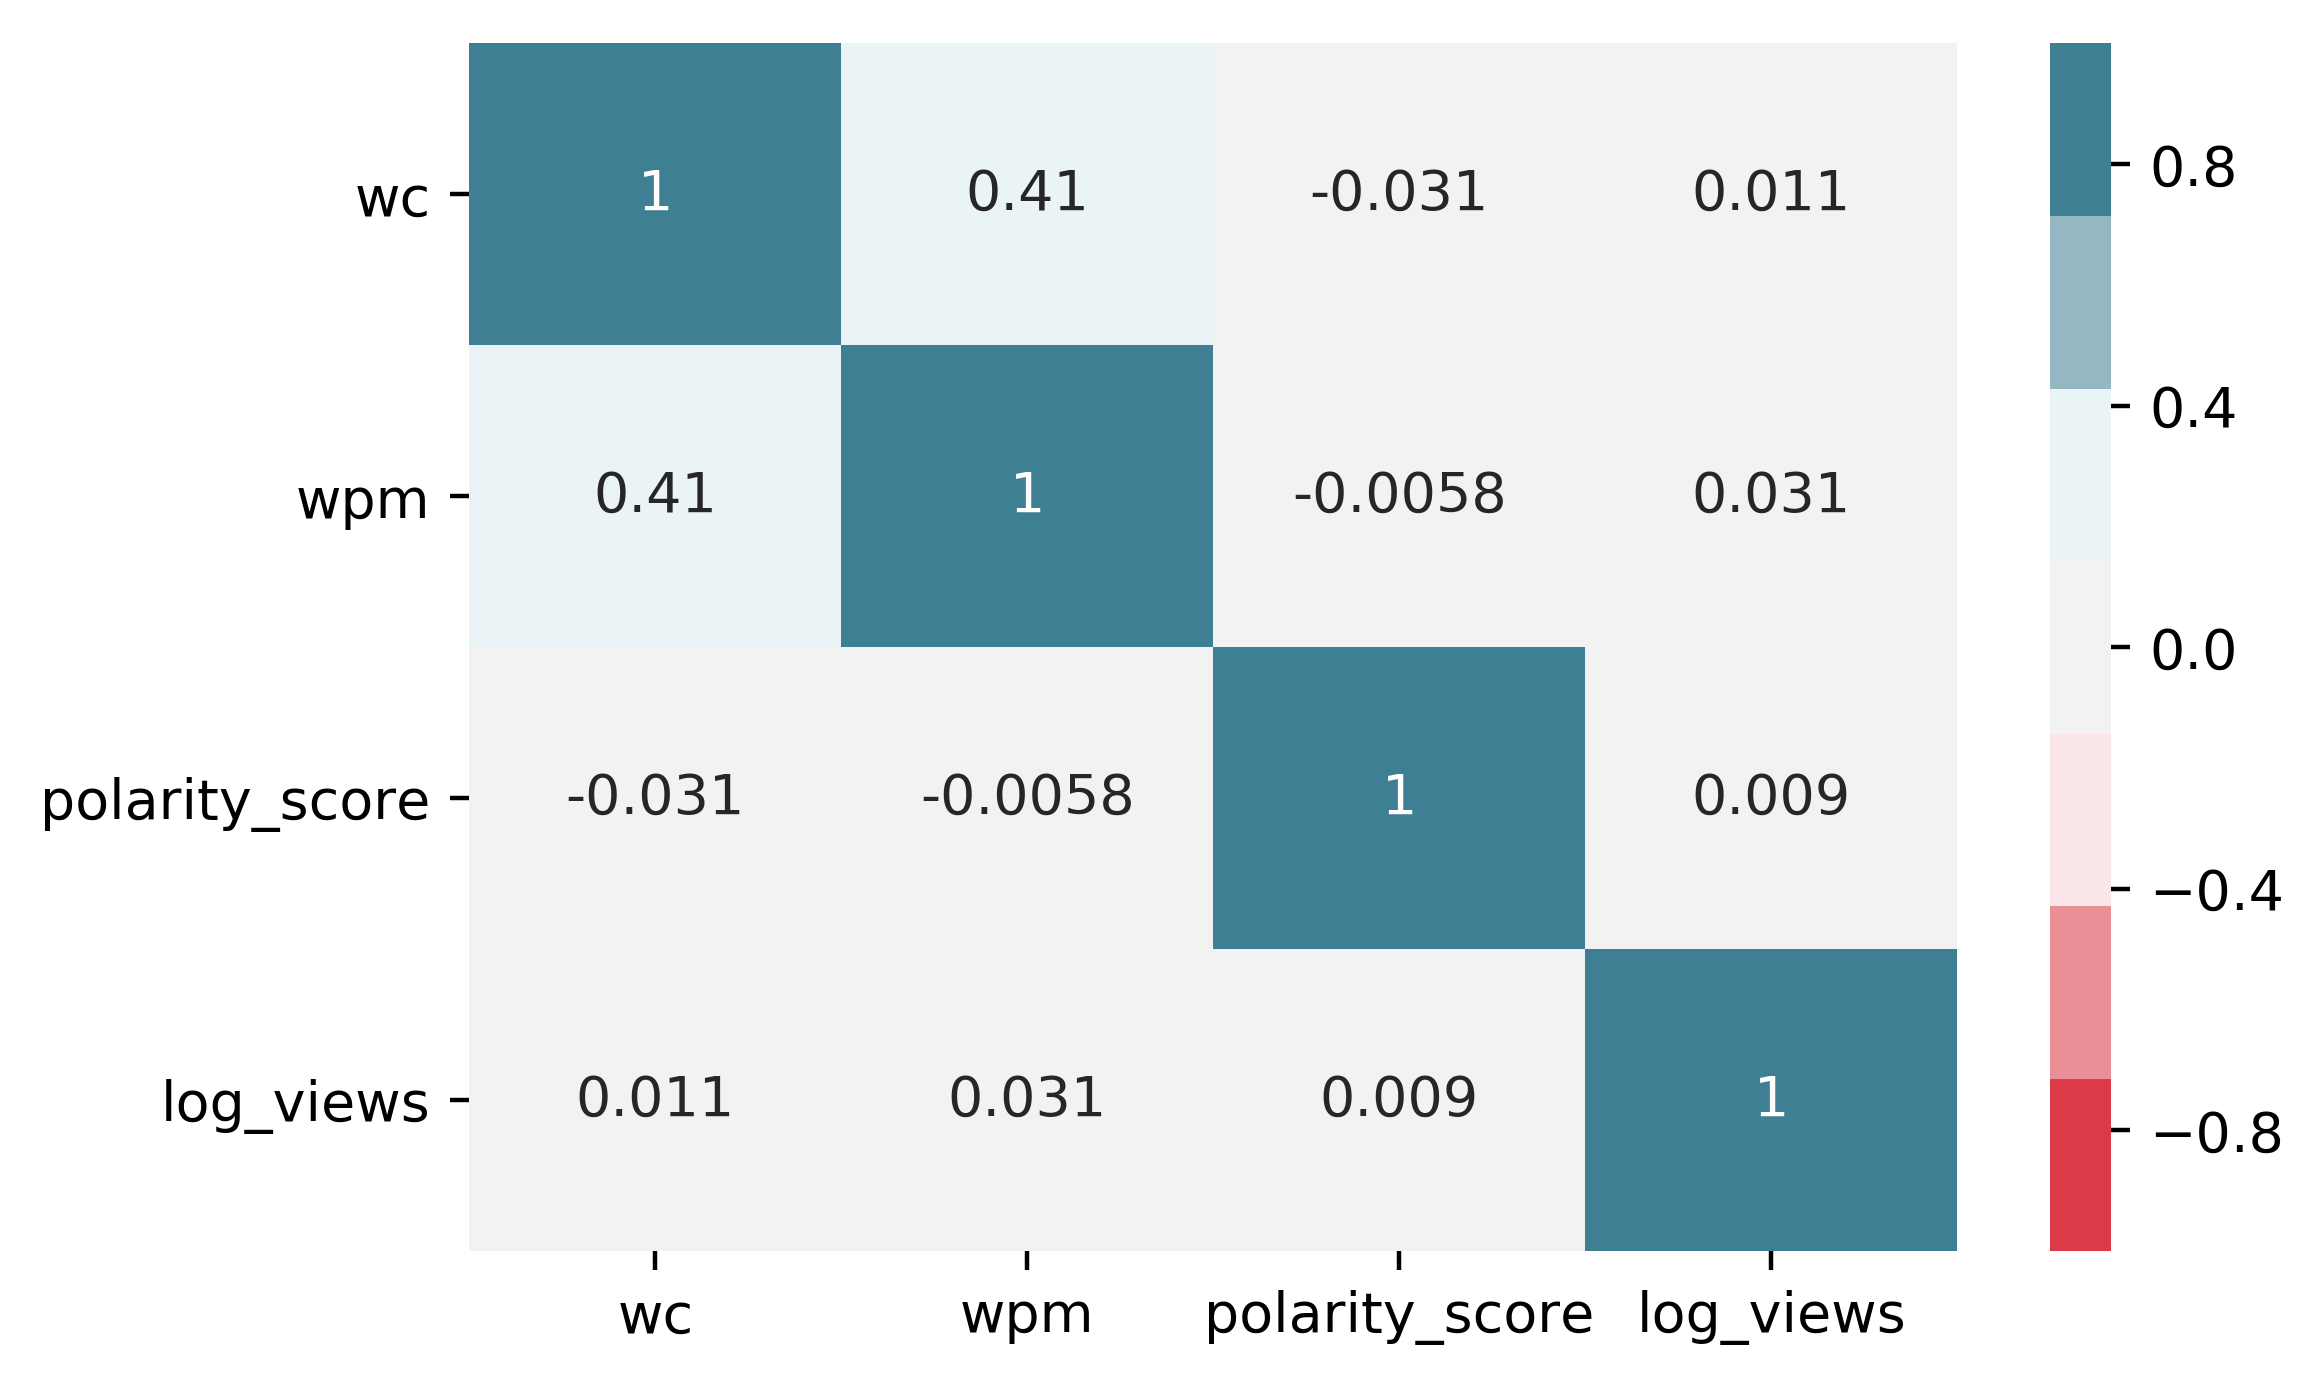

In [723]:
#Checking for relationships in the transcripts
transcripts['log_views'] = data['log_views']
sns.heatmap(transcripts.corr(), vmin=-1, vmax=1,cmap=colors, annot = True)

In [624]:
#Coming Transcript data with the main data frame
transcripts_df = tag_df.join(transcripts)


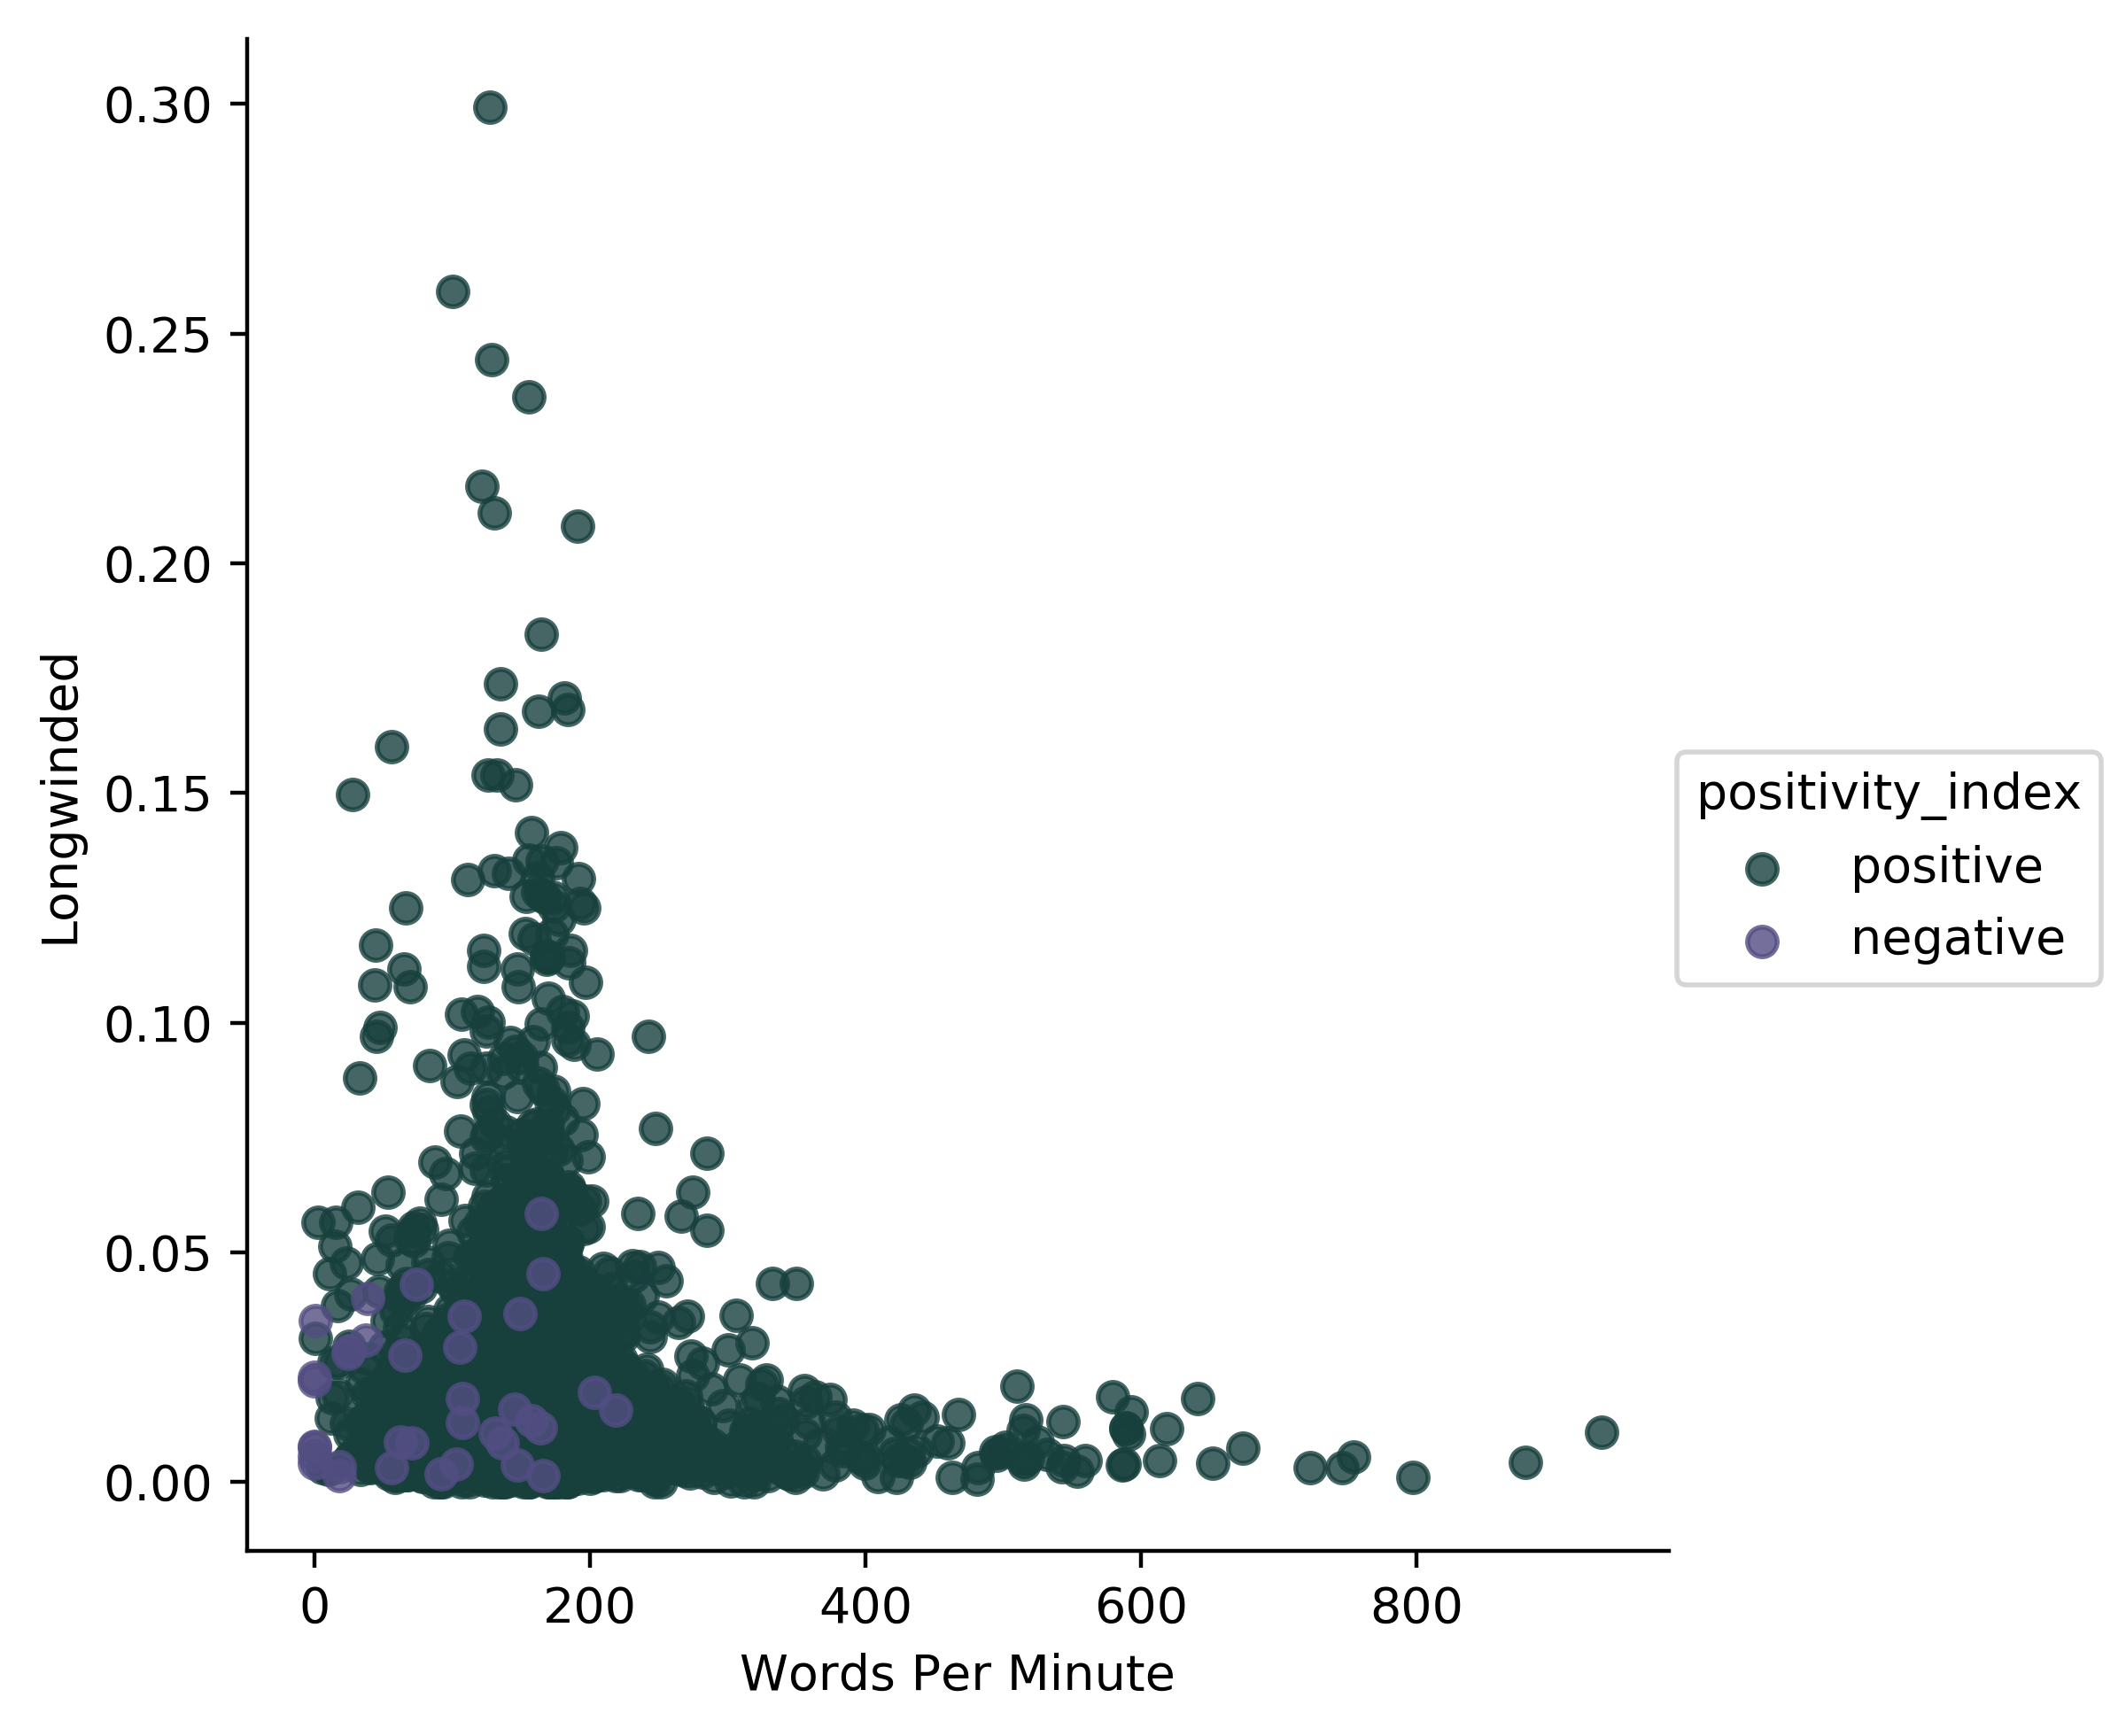

In [625]:
#Checking for a relationship
sns.set_palette(sns.cubehelix_palette(4, start=1.5, rot=1.5, dark=.6, light=.2))
fig = sns.lmplot(y="Longwinded", x='wpm', data=transcripts_df, hue = 'positivity_index', fit_reg = False)
fig = fig.set_axis_labels('Words Per Minute', 'Longwinded')


## Out of Sample Data

Below is reading and testing the model vs out of sample data.  This is how it would have been set up, however, I was not able to get the number of comments and the duration from the videos. This will be left in for future work.

In [643]:
#reading a pickle file
with open("test_data.pkl", 'rb') as picklefun: 
    ofs_dict = pickle.load(picklefun)

In [644]:
ofs_df = pd.DataFrame.from_dict(ofs_dict, orient = 'index')
ofs_df.reset_index(drop = True, inplace=True)

In [645]:
ofs_df.columns = ['date_pub', 'views','tags', 'ratings']
ofs_df['days_online'] = ofs_df['date_pub'].apply(lambda x: ((dateutil.parser.parse('4/21/2018').date()-dateutil.parser.parse(x).date())))
ofs_df['days_online'] = (ofs_df['days_online']/np.timedelta64(1, 'D')).astype(int)
ofs_df['log_views'] = ofs_df['views'].apply(lambda x: math.log(x))

In [646]:
#Pulling out ratings, and then stacking their dataframes
def ratingconcat(rate_col):
    marker = 1
    for i in rate_col:
        next_row = pd.DataFrame(i, index=[0])
        if marker == 1:
            marker = 0
            super_df = next_row
        else:
            super_df = super_df.append(next_row)
    super_df.reset_index(drop = True, inplace=True)
    for i in range(0,len(super_df.index)):
        super_df.loc[i,:] = super_df.loc[i,:] / super_df.loc[i,:].sum()
    super_df = super_df.fillna(0)
    return super_df
 
# Creating a dictionary similar to a default dictionary where the first row will be all 1s
def taggies(extagaganza):
    tags = []
    dummy_dict = {}
    count = 0
    extagaganza.reset_index(drop=True, inplace = True)
    for i in top_tags:
        dummy_dict[i] = [1]
    for k in range(len(extagaganza)):
        for i in top_tags:
            if i in extagaganza[count]:
                dummy_dict[i].append(1)

            else:
                dummy_dict[i].append(0)
    count+=1
    
    return dummy_dict

In [647]:
#pulling out data nested in the initial DF
ofs_tag_dict = taggies(ofs_df.tags)
ofs_rate_df = ratingconcat(ofs_df.ratings)



In [648]:
#Changing dictionary to DF
ofs_tag_df = pd.DataFrame(ofs_tag_dict) 
tag_df.drop(0, inplace=True)
tag_df.reset_index(drop=True, inplace = True)


In [650]:
test_df.reset_index(drop=True, inplace =True)

In [651]:
#Putting it all together and tidying up
ofs_df = ofs_df.join([ofs_tag_df,ofs_rate_df])
ofs_df.drop(['tags','ratings','views','date_pub'], axis=1, inplace = True)

In [655]:
ofs_y = ofs_df.log_views
ofs_X = ofs_df.drop('log_views',1)

In [726]:
#est.score(ofs_X, ofs_y)